## TensorFlow - LSTM
In this notebook we will implement LSTM layer from scratch. Then we will use **LSTM** layer to do time series prediction.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

%matplotlib inline

In [37]:
# Lets define these variables
# N = number of samples
# T = sequence length
# D = number of input features
# M = number of hidden units
# K = number of output units

np.random.seed(42)
N = 1
T = 1
D = 3
K = 2
X = np.random.randn(N, T, D)

In [38]:
# Make an LSTM
M = 5 # number of hidden units
i = Input(shape=(T, D))
x = LSTM(M)(i)
x = Dense(K)(x)

model = Model(i, x)

In [39]:
# Get the output 
Yhat = model.predict(X)
print(Yhat)

[[ 0.15160125 -0.03288027]]


In [32]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10, 3)]           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5)                 180       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 12        
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [40]:
#Check the shapes of the layers
a, b, c = model.layers[1].get_weights()
print(a.shape, b.shape, c.shape)

(3, 20) (5, 20) (20,)


In [41]:
Wx, Wh, bh = model.layers[1].get_weights()
Wo, bo = model.layers[2].get_weights()

In [42]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#Initialize the hidden state
h_last = np.zeros(M)
c_last = np.zeros(M)
#First sample
x = X[0] 
Yhats = []

for t in range(T):
  f = sigmoid(x[t].dot(Wx[:,5:10]) + h_last.dot(Wh[:,5:10]) + bh[5:10]) 
  i = sigmoid(x[t].dot(Wx[:,0:5]) + h_last.dot(Wh[:,0:5]) + bh[0:5]) 
  o = sigmoid(x[t].dot(Wx[:,15:20]) + h_last.dot(Wh[:,15:20]) + bh[15:20]) 
  c = f * c_last + i * np.tanh(x[t].dot(Wx[:,10:15]) + h_last.dot(Wh[:,10:15]) + bh[10:15])
  h = o * np.tanh(c)
  y = h.dot(Wo) + bo 
  Yhats.append(y)
  
  h_last = h
  c_last = c

# print the final output
print(Yhats[-1])

[ 0.1516013  -0.03288028]


Our implementation of **LSTM** layer matches TensorFlow

In [64]:
#Lets make synthetic data
# make the original data
series = np.sin(np.linspace(0,10*np.pi,1000)**2)

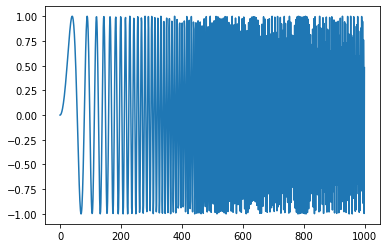

In [65]:
plt.plot(series)

In [66]:
### build the dataset
T = 200
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T) # make it N x T
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (800, 200) Y.shape (800,)


In [70]:
#LSTM Model
X = X.reshape(-1, T, 1) # make it N x T x D

i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.05),
)

# train the RNN
r = model.fit(
  X[:600], Y[:600],
  batch_size=32,
  epochs=200,
  validation_data=(X[600:], Y[600:]),
)

Epoch 1/200
19/19 [==============================] - 1s 68ms/step - loss: 0.2664 - val_loss: 0.2909
Epoch 2/200
19/19 [==============================] - 1s 51ms/step - loss: 0.0475 - val_loss: 0.1026
Epoch 3/200
19/19 [==============================] - 1s 56ms/step - loss: 0.0069 - val_loss: 0.0740
Epoch 4/200
19/19 [==============================] - 1s 59ms/step - loss: 0.0046 - val_loss: 0.0605
Epoch 5/200
19/19 [==============================] - 1s 57ms/step - loss: 0.0025 - val_loss: 0.0457
Epoch 6/200
19/19 [==============================] - 1s 56ms/step - loss: 0.0020 - val_loss: 0.0392
Epoch 7/200
19/19 [==============================] - 1s 56ms/step - loss: 0.0012 - val_loss: 0.0302
Epoch 8/200
19/19 [==============================] - 1s 57ms/step - loss: 0.0012 - val_loss: 0.0310
Epoch 9/200
19/19 [==============================] - 1s 56ms/step - loss: 9.9895e-04 - val_loss: 0.0241
Epoch 10/200
19/19 [==============================] - 1s 56ms/step - loss: 7.9876e-04 - val_loss

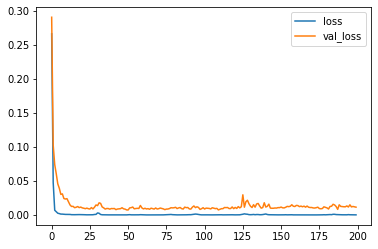

In [71]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

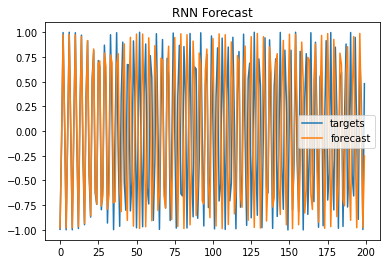

In [79]:
# Multi-step forecast
forecast = []
input = X[600]
while len(forecast) < len(Y[600:800]):
  # Reshape the input to N x T x D
  f = model.predict(input.reshape(1, T, 1))[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input = np.roll(input, -1)
  input[-1] = f

plt.plot(Y[600:800], label='targets')
plt.plot(forecast, label='forecast')
plt.title("LSTM Forecast")
plt.legend()
plt.show()

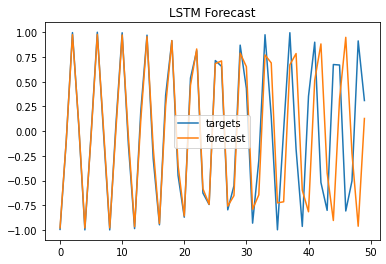

In [82]:
plt.plot(Y[600:650], label='targets')
plt.plot(forecast[:50], label='forecast')
plt.title("LSTM Forecast")
plt.legend()
plt.show()

We can see from the above plots that LSTM did get some prediction correct